In [1]:
from __future__ import division, print_function
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
#In [2]:
DATA_DIR = ""
IMAGE_DIR = os.path.join(DATA_DIR, "holiday-photos/jpg")
WEIGHTS_DIR = os.path.join(DATA_DIR, "weights")

In [9]:
#In [3]:
def get_holiday_triples(image_dir):
    image_groups = {}
    for image_name in os.listdir(image_dir):
        base_name = image_name[0:-4]
        group_name = base_name[0:4]
        if group_name in image_groups:
            image_groups[group_name].append(image_name)
        else:
            image_groups[group_name] = [image_name]
    num_sims = 0
    image_triples = []
    group_list = sorted(list(image_groups.keys()))
    for i, g in enumerate(group_list):
        if num_sims % 100 == 0:
            print("Generated {:d} pos + {:d} neg = {:d} total image triples"
                  .format(num_sims, num_sims, 2*num_sims))
        images_in_group = image_groups[g]
        sim_pairs_it = itertools.combinations(images_in_group, 2)
        # for each similar pair, generate a corresponding different pair
        for ref_image, sim_image in sim_pairs_it:
            image_triples.append((ref_image, sim_image, 1))
            num_sims += 1
            while True:
                j = np.random.randint(low=0, high=len(group_list), size=1)[0]
                if j != i:
                    break
            dif_image_candidates = image_groups[group_list[j]]
            k = np.random.randint(low=0, high=len(dif_image_candidates), size=1)[0]
            dif_image = dif_image_candidates[k]
            image_triples.append((ref_image, dif_image, 0))
    print("Generated {:d} pos + {:d} neg = {:d} total image triples"
          .format(num_sims, num_sims, 2*num_sims))
    return image_triples

def load_vectors(vector_file):
    vec_dict = {}
    fvec = open(vector_file, "r")
    for line in fvec:
        image_name, image_vec = line.strip().split("\t")
        vec = np.array([float(v) for v in image_vec.split(",")])
        vec_dict[image_name] = vec
    fvec.close()
    return vec_dict

def preprocess_data(vector_file, train_size=0.7):
    xdata, ydata = [], []
    vec_dict = load_vectors(vector_file)
    for image_triple in image_triples:
        X1 = vec_dict[image_triple[0]]
        X2 = vec_dict[image_triple[1]]
#         xdata.append(np.multiply(X1, X2) / (np.linalg.norm(X1, 2) * np.linalg.norm(X2, 2)))
        xdata.append(np.abs(np.subtract(X1, X2)))
        ydata.append(image_triple[2])
    X, y = np.array(xdata), np.array(ydata)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    return Xtrain, Xtest, ytrain, ytest

def cross_validate(X, y, clf, k=10):
    best_score, best_clf = 0.0, None
    kfold = KFold(k)
    for kid, (train, test) in enumerate(kfold.split(X, y)):
        Xtrain, Xtest, ytrain, ytest = X[train], X[test], y[train], y[test]
        clf.fit(Xtrain, ytrain)
        ytest_ = clf.predict(Xtest)
        score = accuracy_score(ytest_, ytest)
        print("fold {:d}, score: {:.3f}".format(kid, score))
        if score > best_score:
            best_score = score
            best_clf = clf
    return best_clf, best_score

def test_report(clf, Xtest, ytest):
    ytest_ = clf.predict(Xtest)
    print("\nAccuracy Score: {:.3f}".format(accuracy_score(ytest_, ytest)))
    print("\nConfusion Matrix")
    print(confusion_matrix(ytest_, ytest))
    print("\nClassification Report")
    print(classification_report(ytest_, ytest))
    
def get_model_file(data_dir, vec_name, clf_name):
    return os.path.join(data_dir, "models", "H-{:s}-{:s}-l1.pkl"
                        .format(vec_name, clf_name))

def save_model(model, model_file):
    joblib.dump(model, model_file)

In [10]:
#In [4]:
image_triples = get_holiday_triples(IMAGE_DIR)

Generated 0 pos + 0 neg = 0 total image triples
Generated 300 pos + 300 neg = 600 total image triples
Generated 1100 pos + 1100 neg = 2200 total image triples
Generated 1800 pos + 1800 neg = 3600 total image triples
Generated 2072 pos + 2072 neg = 4144 total image triples


In [11]:
#In [5]:
NUM_VECTORIZERS = 5
NUM_CLASSIFIERS = 4
scores = np.zeros((NUM_VECTORIZERS, NUM_CLASSIFIERS))

Generated 0 pos + 0 neg = 0 total image triples
Generated 300 pos + 300 neg = 600 total image triples
Generated 1100 pos + 1100 neg = 2200 total image triples
Generated 1800 pos + 1800 neg = 3600 total image triples
Generated 2072 pos + 2072 neg = 4144 total image triples


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(2900, 4096) (1244, 4096) (2900,) (1244,)
fold 0, score: 0.834
fold 1, score: 0.817
fold 2, score: 0.859
fold 3, score: 0.810
fold 4, score: 0.807
fold 5, score: 0.841
fold 6, score: 0.783
fold 7, score: 0.783
fold 8, score: 0.845
fold 9, score: 0.834

Accuracy Score: 0.841

Confusion Matrix
[[537 127]
 [ 71 509]]

Classification Report
             precision    recall  f1-score   support

          0       0.88      0.81      0.84       664
          1       0.80      0.88      0.84       580

avg / total       0.84      0.84      0.84      1244

fold 0, score: 0.893
fold 1, score: 0.886
fold 2, score: 0.900
fold 3, score: 0.883
fold 4, score: 0.876
fold 5, score: 0.893
fold 6, score: 0.852
fold 7, score: 0.897
fold 8, score: 0.866
fold 9, score: 0.897

Accuracy Score: 0.897

Confusion Matrix
[[531  51]
 [ 77 585]]

Classification Report
             precision    recall  f1-score   support

          0       0.87      0.91      0.89       582
          1       0.92      0.88      0.90

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 0, score: 0.910


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 1, score: 0.928


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 2, score: 0.941


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 3, score: 0.903


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 4, score: 0.907


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 5, score: 0.903


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 6, score: 0.910


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 7, score: 0.900


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 8, score: 0.945


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 9, score: 0.948

Accuracy Score: 0.933

Confusion Matrix
[[576  51]
 [ 32 585]]

Classification Report
             precision    recall  f1-score   support

          0       0.95      0.92      0.93       627
          1       0.92      0.95      0.93       617

avg / total       0.93      0.93      0.93      1244

fold 0, score: 0.834
fold 1, score: 0.876
fold 2, score: 0.890
fold 3, score: 0.893
fold 4, score: 0.872
fold 5, score: 0.900
fold 6, score: 0.869
fold 7, score: 0.886
fold 8, score: 0.852
fold 9, score: 0.928

Accuracy Score: 0.858

Confusion Matrix
[[560 129]
 [ 48 507]]

Classification Report
             precision    recall  f1-score   support

          0       0.92      0.81      0.86       689
          1       0.80      0.91      0.85       555

avg / total       0.87      0.86      0.86      1244



/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(2900, 4096) (1244, 4096) (2900,) (1244,)
fold 0, score: 0.824
fold 1, score: 0.845
fold 2, score: 0.828
fold 3, score: 0.803
fold 4, score: 0.814
fold 5, score: 0.890
fold 6, score: 0.824
fold 7, score: 0.790
fold 8, score: 0.772
fold 9, score: 0.828

Accuracy Score: 0.831

Confusion Matrix
[[541 128]
 [ 82 493]]

Classification Report
             precision    recall  f1-score   support

          0       0.87      0.81      0.84       669
          1       0.79      0.86      0.82       575

avg / total       0.83      0.83      0.83      1244

fold 0, score: 0.897
fold 1, score: 0.852
fold 2, score: 0.883
fold 3, score: 0.817
fold 4, score: 0.859
fold 5, score: 0.876
fold 6, score: 0.890
fold 7, score: 0.890
fold 8, score: 0.890
fold 9, score: 0.900

Accuracy Score: 0.887

Confusion Matrix
[[532  50]
 [ 91 571]]

Classification Report
             precision    recall  f1-score   support

          0       0.85      0.91      0.88       582
          1       0.92      0.86      0.89

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 0, score: 0.948


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 1, score: 0.910


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 2, score: 0.948


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 3, score: 0.907


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 4, score: 0.900


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 5, score: 0.934


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 6, score: 0.952


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 7, score: 0.921


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 8, score: 0.900


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 9, score: 0.910

Accuracy Score: 0.920

Confusion Matrix
[[569  45]
 [ 54 576]]

Classification Report
             precision    recall  f1-score   support

          0       0.91      0.93      0.92       614
          1       0.93      0.91      0.92       630

avg / total       0.92      0.92      0.92      1244

fold 0, score: 0.928
fold 1, score: 0.897
fold 2, score: 0.900
fold 3, score: 0.893
fold 4, score: 0.907
fold 5, score: 0.862
fold 6, score: 0.862
fold 7, score: 0.855
fold 8, score: 0.852
fold 9, score: 0.876

Accuracy Score: 0.860

Confusion Matrix
[[565 116]
 [ 58 505]]

Classification Report
             precision    recall  f1-score   support

          0       0.91      0.83      0.87       681
          1       0.81      0.90      0.85       563

avg / total       0.86      0.86      0.86      1244



/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(2900, 2048) (1244, 2048) (2900,) (1244,)
fold 0, score: 0.859
fold 1, score: 0.866
fold 2, score: 0.848
fold 3, score: 0.859
fold 4, score: 0.862
fold 5, score: 0.862
fold 6, score: 0.845
fold 7, score: 0.841
fold 8, score: 0.831
fold 9, score: 0.841

Accuracy Score: 0.870

Confusion Matrix
[[595 121]
 [ 41 487]]

Classification Report
             precision    recall  f1-score   support

          0       0.94      0.83      0.88       716
          1       0.80      0.92      0.86       528

avg / total       0.88      0.87      0.87      1244

fold 0, score: 0.897
fold 1, score: 0.883
fold 2, score: 0.890
fold 3, score: 0.859
fold 4, score: 0.866
fold 5, score: 0.924
fold 6, score: 0.907
fold 7, score: 0.876
fold 8, score: 0.924
fold 9, score: 0.883

Accuracy Score: 0.900

Confusion Matrix
[[561  49]
 [ 75 559]]

Classification Report
             precision    recall  f1-score   support

          0       0.88      0.92      0.90       610
          1       0.92      0.88      0.90

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 0, score: 0.928


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 1, score: 0.914


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 2, score: 0.928


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 3, score: 0.914


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 4, score: 0.893


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 5, score: 0.938


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 6, score: 0.931


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 7, score: 0.938


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 8, score: 0.917


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 9, score: 0.903

Accuracy Score: 0.928

Confusion Matrix
[[597  51]
 [ 39 557]]

Classification Report
             precision    recall  f1-score   support

          0       0.94      0.92      0.93       648
          1       0.92      0.93      0.93       596

avg / total       0.93      0.93      0.93      1244

fold 0, score: 0.817
fold 1, score: 0.841
fold 2, score: 0.852
fold 3, score: 0.821
fold 4, score: 0.821
fold 5, score: 0.814
fold 6, score: 0.872
fold 7, score: 0.848
fold 8, score: 0.793
fold 9, score: 0.803

Accuracy Score: 0.826

Confusion Matrix
[[572 153]
 [ 64 455]]

Classification Report
             precision    recall  f1-score   support

          0       0.90      0.79      0.84       725
          1       0.75      0.88      0.81       519

avg / total       0.84      0.83      0.83      1244



/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(2900, 2048) (1244, 2048) (2900,) (1244,)
fold 0, score: 0.803
fold 1, score: 0.848
fold 2, score: 0.824
fold 3, score: 0.793
fold 4, score: 0.838
fold 5, score: 0.803
fold 6, score: 0.872
fold 7, score: 0.834
fold 8, score: 0.852
fold 9, score: 0.838

Accuracy Score: 0.832

Confusion Matrix
[[559 140]
 [ 69 476]]

Classification Report
             precision    recall  f1-score   support

          0       0.89      0.80      0.84       699
          1       0.77      0.87      0.82       545

avg / total       0.84      0.83      0.83      1244

fold 0, score: 0.928
fold 1, score: 0.938
fold 2, score: 0.945
fold 3, score: 0.924
fold 4, score: 0.910
fold 5, score: 0.910
fold 6, score: 0.900
fold 7, score: 0.914
fold 8, score: 0.893
fold 9, score: 0.934

Accuracy Score: 0.899

Confusion Matrix
[[544  42]
 [ 84 574]]

Classification Report
             precision    recall  f1-score   support

          0       0.87      0.93      0.90       586
          1       0.93      0.87      0.90

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 0, score: 0.959


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 1, score: 0.928


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 2, score: 0.931


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 3, score: 0.921


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 4, score: 0.948


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 5, score: 0.928


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 6, score: 0.914


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 7, score: 0.962


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 8, score: 0.934


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 9, score: 0.955

Accuracy Score: 0.946

Confusion Matrix
[[597  36]
 [ 31 580]]

Classification Report
             precision    recall  f1-score   support

          0       0.95      0.94      0.95       633
          1       0.94      0.95      0.95       611

avg / total       0.95      0.95      0.95      1244

fold 0, score: 0.838
fold 1, score: 0.883
fold 2, score: 0.866
fold 3, score: 0.879
fold 4, score: 0.848
fold 5, score: 0.855
fold 6, score: 0.862
fold 7, score: 0.845
fold 8, score: 0.866
fold 9, score: 0.859

Accuracy Score: 0.887

Confusion Matrix
[[590 102]
 [ 38 514]]

Classification Report
             precision    recall  f1-score   support

          0       0.94      0.85      0.89       692
          1       0.83      0.93      0.88       552

avg / total       0.89      0.89      0.89      1244



/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(2900, 2048) (1244, 2048) (2900,) (1244,)
fold 0, score: 0.838
fold 1, score: 0.848
fold 2, score: 0.879
fold 3, score: 0.831
fold 4, score: 0.879
fold 5, score: 0.834
fold 6, score: 0.845
fold 7, score: 0.845
fold 8, score: 0.862
fold 9, score: 0.872

Accuracy Score: 0.860

Confusion Matrix
[[585 137]
 [ 37 485]]

Classification Report
             precision    recall  f1-score   support

          0       0.94      0.81      0.87       722
          1       0.78      0.93      0.85       522

avg / total       0.87      0.86      0.86      1244

fold 0, score: 0.883
fold 1, score: 0.928
fold 2, score: 0.931
fold 3, score: 0.886
fold 4, score: 0.897
fold 5, score: 0.910
fold 6, score: 0.917
fold 7, score: 0.910
fold 8, score: 0.938
fold 9, score: 0.931

Accuracy Score: 0.918

Confusion Matrix
[[566  46]
 [ 56 576]]

Classification Report
             precision    recall  f1-score   support

          0       0.91      0.92      0.92       612
          1       0.93      0.91      0.92

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 0, score: 0.931


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 1, score: 0.924


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 2, score: 0.938


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 3, score: 0.900


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 4, score: 0.931


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 5, score: 0.938


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 6, score: 0.910


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 7, score: 0.907


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 8, score: 0.931


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 9, score: 0.945

Accuracy Score: 0.932

Confusion Matrix
[[590  53]
 [ 32 569]]

Classification Report
             precision    recall  f1-score   support

          0       0.95      0.92      0.93       643
          1       0.91      0.95      0.93       601

avg / total       0.93      0.93      0.93      1244

fold 0, score: 0.852
fold 1, score: 0.831
fold 2, score: 0.859
fold 3, score: 0.828
fold 4, score: 0.862
fold 5, score: 0.841
fold 6, score: 0.824
fold 7, score: 0.821
fold 8, score: 0.862
fold 9, score: 0.866

Accuracy Score: 0.843

Confusion Matrix
[[576 149]
 [ 46 473]]

Classification Report
             precision    recall  f1-score   support

          0       0.93      0.79      0.86       725
          1       0.76      0.91      0.83       519

avg / total       0.86      0.84      0.84      1244



Text(0.5,1,'absolute difference of vectors')

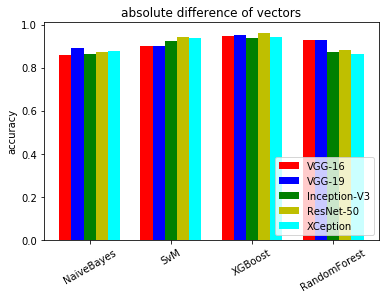

In [6]:
#VGG-16 Vectors
#In [6]:
VECTOR_FILE = os.path.join(DATA_DIR, "vgg16-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)
# (2900, 4096) (1244, 4096) (2900,) (1244,)
# Naive Bayes
# In [7]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "nb"))

# SVM
# In [8]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "svm"))

# XGBoost
# In [9]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "xgb"))

# Random Forest
# In [10]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "rf"))

In [ ]:
# VGG-19
# In [11]:
VECTOR_FILE = os.path.join(DATA_DIR, "vgg19-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

# In [12]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "nb"))

# SVM
# In [13]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "svm"))

# XGBoost
# In [14]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "xgb"))

# Random Forest
# In [15]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "rf"))

In [12]:
# Inception V3
# In [16]:
VECTOR_FILE = os.path.join(DATA_DIR, "inception-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)
# (2900, 2048) (1244, 2048) (2900,) (1244,)
# Naive Bayes
# In [17]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "nb"))

# SVM
# In [18]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "svm"))

# XGBoost
# In [19]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "xgb"))

# Random Forest
# In [20]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "rf"))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(2900, 2048) (1244, 2048) (2900,) (1244,)
fold 0, score: 0.876
fold 1, score: 0.869
fold 2, score: 0.869
fold 3, score: 0.855
fold 4, score: 0.869
fold 5, score: 0.845
fold 6, score: 0.848
fold 7, score: 0.852
fold 8, score: 0.838
fold 9, score: 0.876

Accuracy Score: 0.848

Confusion Matrix
[[556 147]
 [ 42 499]]

Classification Report
             precision    recall  f1-score   support

          0       0.93      0.79      0.85       703
          1       0.77      0.92      0.84       541

avg / total       0.86      0.85      0.85      1244

fold 0, score: 0.897
fold 1, score: 0.893
fold 2, score: 0.869
fold 3, score: 0.879
fold 4, score: 0.924
fold 5, score: 0.928
fold 6, score: 0.855
fold 7, score: 0.903
fold 8, score: 0.890
fold 9, score: 0.890

Accuracy Score: 0.888

Confusion Matrix
[[515  56]
 [ 83 590]]

Classification Report
             precision    recall  f1-score   support

          0       0.86      0.90      0.88       571
          1       0.91      0.88      0.89

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 0, score: 0.921


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 1, score: 0.934


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 2, score: 0.910


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 3, score: 0.914


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 4, score: 0.924


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 5, score: 0.914


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 6, score: 0.914


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 7, score: 0.907


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 8, score: 0.921


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 9, score: 0.931

Accuracy Score: 0.905

Confusion Matrix
[[561  81]
 [ 37 565]]

Classification Report
             precision    recall  f1-score   support

          0       0.94      0.87      0.90       642
          1       0.87      0.94      0.91       602

avg / total       0.91      0.91      0.91      1244

fold 0, score: 0.817
fold 1, score: 0.810
fold 2, score: 0.841
fold 3, score: 0.862
fold 4, score: 0.803
fold 5, score: 0.807
fold 6, score: 0.810
fold 7, score: 0.845
fold 8, score: 0.852
fold 9, score: 0.862

Accuracy Score: 0.823

Confusion Matrix
[[562 184]
 [ 36 462]]

Classification Report
             precision    recall  f1-score   support

          0       0.94      0.75      0.84       746
          1       0.72      0.93      0.81       498

avg / total       0.85      0.82      0.82      1244



In [ ]:
# ResNet 50
# In [21]:
VECTOR_FILE = os.path.join(DATA_DIR, "resnet-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)
# (2900, 2048) (1244, 2048) (2900,) (1244,)
# Naive Bayes
# In [22]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "nb"))

# SVM
# In [23]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "svm"))

# XGBoost
# In [24]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "xgb"))

# Random Forest
# In [25]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "rf"))

In [ ]:
# Xception
# In [26]:
VECTOR_FILE = os.path.join(DATA_DIR, "xception-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)
# (2900, 2048) (1244, 2048) (2900,) (1244,)
# Naive Bayes
# In [27]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "nb"))

# SVM
# In [28]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "svm"))

# XGBoost
# In [29]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "xgb"))

# Random Forest
# In [30]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "rf"))

In [ ]:
# In [31]:
scores

# In [33]:
width=0.15
plt.bar(np.arange(NUM_CLASSIFIERS), scores[0], width, color="r", label="VGG-16")
plt.bar(np.arange(NUM_CLASSIFIERS)+width, scores[1], width, color="b", label="VGG-19")
plt.bar(np.arange(NUM_CLASSIFIERS)+2*width, scores[2], width, color="g", label="Inception-V3")
plt.bar(np.arange(NUM_CLASSIFIERS)+3*width, scores[3], width, color="y", label="ResNet-50")
plt.bar(np.arange(NUM_CLASSIFIERS)+4*width, scores[4], width, color="cyan", label="XCeption")
plt.legend(loc=4)
plt.ylabel("accuracy")
plt.xticks(np.arange(NUM_CLASSIFIERS)+2*width, ["NaiveBayes", "SvM", "XGBoost", "RandomForest"],
          rotation=30)
plt.title("absolute difference of vectors")